# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

Recall out difficulty evaluators:

In [66]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.optim import Adam, SGD

from helpers import SimpleTRE, SimpleDE, create_state
from shared_parameters import *
from utils import MLP, TrainUntil


In [33]:
enemy_x = np.linspace(enemy_x_min, enemy_x_max, 100)
states = np.array([create_state(x) for x in enemy_x])

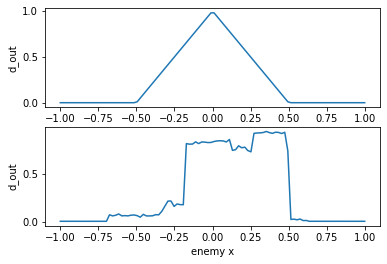

In [34]:
evaluators = SimpleDE(), SimpleTRE()
evaluations = [evaluator.evaluate(states) for evaluator in evaluators]

fig, axs = plt.subplots(2)

for ax, ev in zip(axs, evaluations):
    ax.plot(enemy_x, ev)
    ax.set_xlabel("enemy x")
    ax.set_ylabel("d_out")

plt.show()

We see that for the same difficulty, there exist several levels, that have the same difficulty.
However, with the way we've set up our generators, they can only output a single level for the given difficulty.

Now let's give the generator two inputs: the input difficulty $d_{in}$, as well the seed $\epsilon$

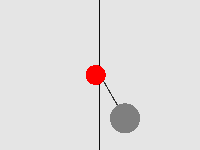

In [35]:
d_in = np.linspace(0, 1, 100)
seeds = np.linspace(0, 1, 100)

# Cartesian product of difficulties and seeds
difficulties_and_seeds = np.transpose([np.tile(d_in, len(seeds)), np.repeat(seeds, len(d_in))])
difficulties_and_seeds = torch.from_numpy(difficulties_and_seeds).type(torch.float32)

d_in = difficulties_and_seeds[:, 0].unsqueeze(1)
seeds = difficulties_and_seeds[:, 1].unsqueeze(1)

First, let's train our evaluator, using the `TrajectoryRewardsEvaluator` as an oracle

10000 0.0010784333571791649
Done after 10001 iteration(s). Loss: 0.001079
10001 iterations to train evaluator from the oracle


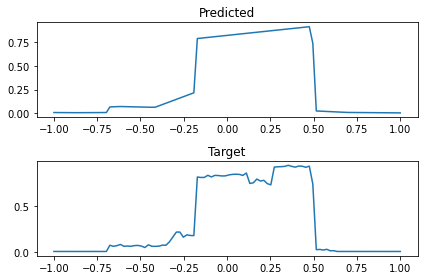

In [40]:
oracle_evaluation = evaluations[1]

evaluator = MLP(1, 1, [4, 8, 8, 4], activation="lrelu")
optim_evaluator = Adam(evaluator.parameters(), lr=0.001)

x = torch.from_numpy(enemy_x).type(torch.float32).unsqueeze(1)
target = torch.from_numpy(evaluations[1]).type(torch.float32).unsqueeze(1)


with TrainUntil(1e-5, 100, 10000) as trainer:
    while not trainer.done:
        predicted = evaluator(x)

        loss = ((predicted - target) ** 2).mean()

        optim_evaluator.zero_grad()
        loss.backward()
        optim_evaluator.step()

        if (trainer.iteration + 1) % 100 == 0:
            clear_output(wait=True)
            print(trainer.iteration + 1, loss.item())

        trainer.loss = loss

print(trainer.iteration, "iterations to train evaluator from the oracle")

fig, axs = plt.subplots(2)
axs[0].plot(x, predicted.detach())
axs[0].set_title("Predicted")
axs[1].plot(x, target.detach())
axs[1].set_title("Target")
plt.tight_layout()

Now the task is to maximize diversity proportionally to the difference in the $epsilon$ seed.

### How do we compute difference between two levels?

One way would be to take the $L_2$ norm of the difference of the levels (or levels embedding).
However, this has an obvious drawback that different components of the embedding vector contribute
differently to the actual level, and, thus, to the difference. For example, one component might contain
the total number of enemies, and other components may contain the enemies' positions, radii, etc.

A rather more precise way to compare the difference would be to run simulations with the different
agents, and compare the resulting trajectories. Each agent would then generate the distribution of
their trajectories. We can then compare those distributions for the different embeddings to obtain the
diversity.

> For simplicity, in our case, we will now compute the level difference as the difference in the
> $x_{enemy}$ between the different levels

### Caching the diversity

Similarly to how we handled the difficulty evaluation, we can train a NN approximator to compute the level
difference. This may be feasible for more complex environments, but for our case, we will suffice with
just comparing the $x_{enemy}$ in the embeddings.

In [69]:
# For the expensive difference computation, it's more feasible to use GPU

generator = MLP(2, 1, [4, 6, 8, 6, 4]).cuda()
optim_generator = Adam(generator.parameters(), lr=0.01)

evaluator.cuda()
seeds.cuda()
d_in.cuda()
difficulties_and_seeds.cuda()

seeds_differences = (seeds.unsqueeze(0) - seeds.unsqueeze(1)).abs()

with TrainUntil(0.01, 50, 10000, print_frequency=5, clear=True) as trainer:
    while not trainer.done:
        levels = generator(difficulties_and_seeds)
        d_out = evaluator(levels)

        difficulty_loss = (d_in - d_out).abs().mean()
        constrain_loss = ((levels.clip(enemy_x_min, enemy_x_max) - levels) ** 2).mean()

        # we need to find the distance between each two levels
        diversity = levels.unsqueeze(0) - levels.unsqueeze(1)
        diversity = diversity * seeds_differences
        diversity = torch.linalg.norm(diversity, dim=-1).mean()

        loss = difficulty_loss + 10 * constrain_loss - 0.1 * diversity

        optim_generator.zero_grad()
        loss.backward()
        optim_generator.step()

        trainer.loss = difficulty_loss
        print(difficulty_loss.item(), constrain_loss.item(), diversity.item())


KeyboardInterrupt: 

In a perfect world this would work, but what happens is that diversity keeps pushing levels apart,
while the difficulty difference loss holds them together. Ideally y we would like to somehow explore
the level space in a sensible way, but in reallity we're still constained to some closed interval
of values.